# Forecasting Electricity Demand: Exploring Predictive Models with PJM Hourly Load Data


### This project aims to explore and model electricity load data from the PJM Interconnection.PJM is a regional transmission organization (RTO) that coordinates the movement of wholesale electricity in all or parts of 13 states and the District of Columbia.more details can be found here.The dataset used in this analysis is the "PJM hourly Hourly Load: Metered data for AP zone."The dataset contains 8 columns:.Trough this notebook my aim is to buit machine learning based predictive model(Random Forest) to generate day-ahead forecast values for an ISO level load dataset.For this my analysis included data cleaning,Seasonal analysis,Modelling and visualizations.This notebook will make use of some basic Python, pandas, and Numpy.

## Setup

Here are some of the basic modules you'll need for this problem.

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.feature_selection import RFE

## Get to know the dataset: PJM Hourly Load: Metered

The dataset used in this analysis is the "PJM hourly Hourly Load: Metered data for AP zone.The dataset consists of hrl_load_metered_AP.Here i only used AP zone region for my analysis and the dataset can be dowloaded from this link.Run this code cell to load the data into a pandas DataFrame named pjm_load and inspect a small sample.


In [147]:
pjm_load = pd.read_csv('hrl_load_metered_AP.csv')

In [148]:
pjm_load

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/2023 5:00,1/1/2023 0:00,RFC,WEST,AP,AP,4634.392,True
1,1/1/2023 6:00,1/1/2023 1:00,RFC,WEST,AP,AP,4534.132,True
2,1/1/2023 7:00,1/1/2023 2:00,RFC,WEST,AP,AP,4465.419,True
3,1/1/2023 8:00,1/1/2023 3:00,RFC,WEST,AP,AP,4446.937,True
4,1/1/2023 9:00,1/1/2023 4:00,RFC,WEST,AP,AP,4477.269,True
...,...,...,...,...,...,...,...,...
8755,1/1/2024 0:00,12/31/2023 19:00,RFC,WEST,AP,AP,5896.602,True
8756,1/1/2024 1:00,12/31/2023 20:00,RFC,WEST,AP,AP,5758.356,True
8757,1/1/2024 2:00,12/31/2023 21:00,RFC,WEST,AP,AP,5610.514,True
8758,1/1/2024 3:00,12/31/2023 22:00,RFC,WEST,AP,AP,5467.885,True


Here i only need the dataset contains two columns: "datetime_beginning_ept" representing the timestamp and "mw" representing the electricity load in megawatts.

In [149]:
df_pjm_load_required = pjm_load[['datetime_beginning_ept','mw']]

In [150]:
print(df_pjm_load_required.dtypes)

datetime_beginning_ept     object
mw                        float64
dtype: object


## Data Cleaning

Through next couple of cells am doing several cleaning steps, including sorting by datetime, removing duplicate entries, and filling missing values using forward filling (ffill)documentation method.

In [151]:
df_pjm_load = df_pjm_load_required.copy()
df_pjm_load.loc[:, 'datetime'] = pd.to_datetime(df_pjm_load['datetime_beginning_ept'])

In [152]:
df_pjm_load

,datetime_beginning_ept,mw,datetime
0,1/1/2023 0:00,4634.392,2023-01-01 00:00:00
1,1/1/2023 1:00,4534.132,2023-01-01 01:00:00
2,1/1/2023 2:00,4465.419,2023-01-01 02:00:00
3,1/1/2023 3:00,4446.937,2023-01-01 03:00:00
4,1/1/2023 4:00,4477.269,2023-01-01 04:00:00
...,...,...,...
8755,12/31/2023 19:00,5896.602,2023-12-31 19:00:00
8756,12/31/2023 20:00,5758.356,2023-12-31 20:00:00
8757,12/31/2023 21:00,5610.514,2023-12-31 21:00:00
8758,12/31/2023 22:00,5467.885,2023-12-31 22:00:00


<AxesSubplot:xlabel='Date time', ylabel='Load (MW)'>

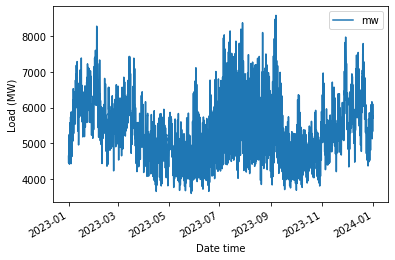

In [153]:
df_pjm_load.plot(x='datetime', y='mw', xlabel='Date time', ylabel='Load (MW)' )

Data cleaning

Data sorting

In [154]:
df_pjm_load = df_pjm_load.sort_values(by='datetime', ascending= True)

In [155]:
df_pjm_load

,datetime_beginning_ept,mw,datetime
0,1/1/2023 0:00,4634.392,2023-01-01 00:00:00
1,1/1/2023 1:00,4534.132,2023-01-01 01:00:00
2,1/1/2023 2:00,4465.419,2023-01-01 02:00:00
3,1/1/2023 3:00,4446.937,2023-01-01 03:00:00
4,1/1/2023 4:00,4477.269,2023-01-01 04:00:00
...,...,...,...
8755,12/31/2023 19:00,5896.602,2023-12-31 19:00:00
8756,12/31/2023 20:00,5758.356,2023-12-31 20:00:00
8757,12/31/2023 21:00,5610.514,2023-12-31 21:00:00
8758,12/31/2023 22:00,5467.885,2023-12-31 22:00:00


In [156]:
duplicates = df_pjm_load.duplicated(subset='datetime', keep=False)
print(df_pjm_load[duplicates])

     datetime_beginning_ept        mw            datetime
7392         11/5/2023 1:00  4320.282 2023-11-05 01:00:00
7393         11/5/2023 1:00  4257.227 2023-11-05 01:00:00


In [157]:
df_pjm_load = df_pjm_load.drop_duplicates(subset=['datetime'], keep='last')

In [158]:
duplicates = df_pjm_load.duplicated(subset='datetime', keep=False)
print(df_pjm_load[duplicates])

Empty DataFrame
Columns: [datetime_beginning_ept, mw, datetime]
Index: []


In [159]:
df_pjm_load = df_pjm_load.set_index('datetime')

In [160]:
full_range = pd.date_range(start=df_pjm_load.index.min(), end=df_pjm_load.index.max(), freq='H')


In [161]:
full_range

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [162]:
missing_hours = full_range.difference(df_pjm_load.index)
print(missing_hours)

DatetimeIndex(['2023-03-12 02:00:00'], dtype='datetime64[ns]', freq=None)


In [163]:
print(df_pjm_load.isna().any())

datetime_beginning_ept    False
mw                        False
dtype: bool


In [164]:
df_pjm_load_cleaned = df_pjm_load.resample('H').ffill()

In [165]:
df_pjm_load_cleaned

,datetime_beginning_ept,mw
datetime,,
2023-01-01 00:00:00,1/1/2023 0:00,4634.392
2023-01-01 01:00:00,1/1/2023 1:00,4534.132
2023-01-01 02:00:00,1/1/2023 2:00,4465.419
2023-01-01 03:00:00,1/1/2023 3:00,4446.937
2023-01-01 04:00:00,1/1/2023 4:00,4477.269
...,...,...
2023-12-31 19:00:00,12/31/2023 19:00,5896.602
2023-12-31 20:00:00,12/31/2023 20:00,5758.356
2023-12-31 21:00:00,12/31/2023 21:00,5610.514


In [166]:
missing_hours = full_range.difference(df_pjm_load_cleaned.index)
print(missing_hours)

DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [167]:
#df_pjm_load_cleaned.reset_index()

In [168]:
#df_pjm_load_cleaned.set_index('datetime', inplace=True)

In [169]:
df_pjm_load_cleaned

,datetime_beginning_ept,mw
datetime,,
2023-01-01 00:00:00,1/1/2023 0:00,4634.392
2023-01-01 01:00:00,1/1/2023 1:00,4534.132
2023-01-01 02:00:00,1/1/2023 2:00,4465.419
2023-01-01 03:00:00,1/1/2023 3:00,4446.937
2023-01-01 04:00:00,1/1/2023 4:00,4477.269
...,...,...
2023-12-31 19:00:00,12/31/2023 19:00,5896.602
2023-12-31 20:00:00,12/31/2023 20:00,5758.356
2023-12-31 21:00:00,12/31/2023 21:00,5610.514


## Seasonal Analysis
Data was split into seasons: winter, spring, summer, and fall.The dataset was segmented into four seasons: winter, spring, summer, and fall. Each season's data was extracted and analyzed separately to understand seasonal load patterns.


In [183]:
start_date ='2023-01-01 00:00:00'
end_date = '2023-03-31 23:00:00'
df_pjm_load_winter = df_pjm_load_cleaned[start_date:end_date]
df_pjm_load_winter=df_pjm_load_winter.reset_index()
df_pjm_load_winter


,datetime,datetime_beginning_ept,mw
0,2023-01-01 00:00:00,1/1/2023 0:00,4634.392
1,2023-01-01 01:00:00,1/1/2023 1:00,4534.132
2,2023-01-01 02:00:00,1/1/2023 2:00,4465.419
3,2023-01-01 03:00:00,1/1/2023 3:00,4446.937
4,2023-01-01 04:00:00,1/1/2023 4:00,4477.269
...,...,...,...
2155,2023-03-31 19:00:00,3/31/2023 19:00,5455.426
2156,2023-03-31 20:00:00,3/31/2023 20:00,5431.480
2157,2023-03-31 21:00:00,3/31/2023 21:00,5252.801
2158,2023-03-31 22:00:00,3/31/2023 22:00,4959.678


<AxesSubplot:xlabel='Date time', ylabel='Load (MW)'>

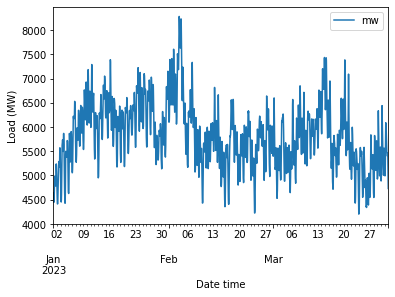

In [184]:
df_pjm_load_winter.plot(x='datetime', y='mw', xlabel='Date time', ylabel='Load (MW)' )

In [185]:
start_date ='2023-04-01 00:00:00'
end_date = '2023-06-30 23:00:00'
df_pjm_load_spring = df_pjm_load_cleaned[start_date:end_date]
df_pjm_load_spring=df_pjm_load_spring.reset_index()
df_pjm_load_spring


,datetime,datetime_beginning_ept,mw
0,2023-04-01 00:00:00,4/1/2023 0:00,4535.860
1,2023-04-01 01:00:00,4/1/2023 1:00,4329.427
2,2023-04-01 02:00:00,4/1/2023 2:00,4228.328
3,2023-04-01 03:00:00,4/1/2023 3:00,4178.324
4,2023-04-01 04:00:00,4/1/2023 4:00,4209.014
...,...,...,...
2179,2023-06-30 19:00:00,6/30/2023 19:00,6317.317
2180,2023-06-30 20:00:00,6/30/2023 20:00,6120.336
2181,2023-06-30 21:00:00,6/30/2023 21:00,5937.785
2182,2023-06-30 22:00:00,6/30/2023 22:00,5560.487


<AxesSubplot:xlabel='Date time', ylabel='Load (MW)'>

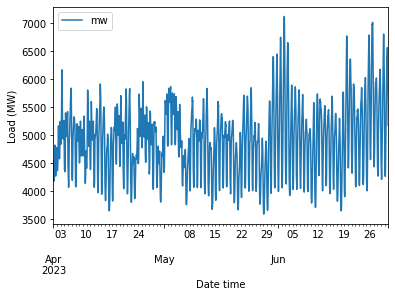

In [186]:
df_pjm_load_spring.plot(x='datetime', y='mw', xlabel='Date time', ylabel='Load (MW)' )

In [192]:
start_date ='2023-07-01 00:00:00'
end_date = '2023-09-30 23:00:00'
df_pjm_load_summer = df_pjm_load_cleaned[start_date:end_date]
df_pjm_load_summer=df_pjm_load_summer.reset_index()
df_pjm_load_summer


,datetime,datetime_beginning_ept,mw
0,2023-07-01 00:00:00,7/1/2023 0:00,4792.761
1,2023-07-01 01:00:00,7/1/2023 1:00,4592.205
2,2023-07-01 02:00:00,7/1/2023 2:00,4401.926
3,2023-07-01 03:00:00,7/1/2023 3:00,4292.638
4,2023-07-01 04:00:00,7/1/2023 4:00,4275.415
...,...,...,...
2203,2023-09-30 19:00:00,9/30/2023 19:00,5130.454
2204,2023-09-30 20:00:00,9/30/2023 20:00,4999.212
2205,2023-09-30 21:00:00,9/30/2023 21:00,4786.570
2206,2023-09-30 22:00:00,9/30/2023 22:00,4520.885


<AxesSubplot:xlabel='Date time', ylabel='Load (MW)'>

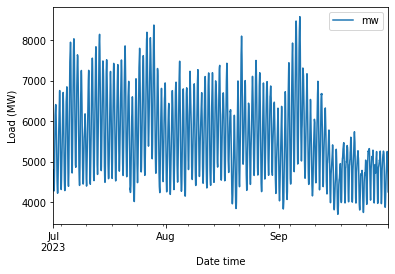

In [193]:
df_pjm_load_summer.plot(x='datetime', y='mw', xlabel='Date time', ylabel='Load (MW)' )

In [194]:
start_date ='2023-10-01 00:00:00'
end_date = '2023-12-31 23:00:00'
df_pjm_load_fall = df_pjm_load_cleaned[start_date:end_date]
df_pjm_load_fall=df_pjm_load_fall.reset_index()
df_pjm_load_fall


,datetime,datetime_beginning_ept,mw
0,2023-10-01 00:00:00,10/1/2023 0:00,4042.513
1,2023-10-01 01:00:00,10/1/2023 1:00,3850.067
2,2023-10-01 02:00:00,10/1/2023 2:00,3734.200
3,2023-10-01 03:00:00,10/1/2023 3:00,3687.402
4,2023-10-01 04:00:00,10/1/2023 4:00,3679.819
...,...,...,...
2203,2023-12-31 19:00:00,12/31/2023 19:00,5896.602
2204,2023-12-31 20:00:00,12/31/2023 20:00,5758.356
2205,2023-12-31 21:00:00,12/31/2023 21:00,5610.514
2206,2023-12-31 22:00:00,12/31/2023 22:00,5467.885


<AxesSubplot:xlabel='Date time', ylabel='Load (MW)'>

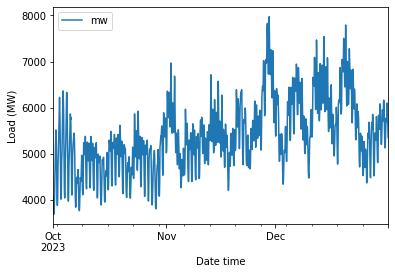

In [195]:
df_pjm_load_fall.plot(x='datetime', y='mw', xlabel='Date time', ylabel='Load (MW)' )

## Visualization

Load patterns for each season were visualized above using line plots, showing the variation in load over time. The plots highlight differences in load behavior between seasons.Winter: The load tends to be higher during peak hours compared to other seasons, likely due to increased heating demand. Spring: Load shows more fluctuation compared to winter, indicating a transition period with varying energy demands. Summer: Load peaks during the afternoon and early evening, likely due to increased air conditioning usage. Fall: Load patterns resemble spring but with slightly lower overall demand as temperatures begin to decrease.

## Feature Engineering and Modeling

Here my aim is to buit machine learning based predictive model(Random Forest) to generate day-ahead forecast values.For that i used RANDOM FOREST.
Random Forest Regression

Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique.Random Forest Regression is like having a bunch of smart trees in a forest, each giving its own opinion. By combining their opinions, we get a more reliable prediction. It's a powerful tool in machine learning, especially useful for beginners due to its simplicity and effectiveness in many situations.

Why Use Random Forest?

Good for Many Situations: Random Forest can handle both regression and classification tasks. It's versatile and can work well with various types of data.
Handles Complex Relationships: It's robust to outliers and works well even with non-linear relationships between features and the target variable.
Less Prone to Overfitting: Because it combines the predictions of multiple trees, it's less likely to overfit the training data compared to a single decision tree.

When to Use Random Forest?

Large Datasets: It's effective with large datasets with many features.
No Need for Feature Scaling: Random Forest doesn't require scaling of features, making it easier to use with different types of data.
Interpretability: While each tree might be hard to interpret individually, Random Forest can still provide insights into feature importance.

TASKS: Creating the function feature_addition for preparing the PJM hourly load data for predictive modeling tasks by incorporating relevant time-based and date-based features, which can potentially improve the accuracy of electricity demand forecasts.

In [174]:
def feature_addition(df_pjm_data_season):
    
    dataframe = pd.DataFrame()
    # Adding the time lags
    for i in range(24, 20, -1):
       dataframe['t-' + str(i)] = df_pjm_data_season.mw.shift(i)
    final_data = pd.concat([df_pjm_data_season, dataframe], axis=1)
    final_data.dropna(inplace=True)
    
    # Adding the date time features
    final_data['hour'] = final_data['datetime'].dt.hour
    final_data['date'] = final_data['datetime'].dt.day
    final_data['month'] = final_data['datetime'].dt.month
    return final_data

Creating the function train_test, is used to split the dataset into training and testing sets for machine learning model evaluation. This function should do following tasks

1. Remove DateTime Columns: The function first removes the columns 'datetime' and 'datetime_beginning_ept' from the dataset as they are not used as features for modeling. This is done using the drop method.

2. Calculate Test Length: The length of the test set is calculated based on the number of days (31) multiplied by the number of hours in a day (24).

3. Split Training and Testing Data: The dataset is split into training and testing sets. The training set consists of data up to the index x - 1, and the testing set consists of data from index x onwards.

4. Separate Features and Target Variable: For both the training and testing sets, the features (all columns except 'mw') and the target variable ('mw') are separated into different variables (finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y). This separation is necessary for training and evaluating machine learning models.

In [ ]:
def train_test(final_data):
    finaldf = final_data.drop([ 'datetime','datetime_beginning_ept'], axis=1)
    finaldf = finaldf.reset_index(drop=True)
    # test length
    test_length= 31*24
    end_point = len(finaldf)
    
    x = end_point - test_length
    # Training data
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'mw']
    finaldf_train_y = finaldf_train['mw']  
    # Testing data
    finaldf_test = finaldf.loc[x:, :]
    finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'mw']
    finaldf_test_y = finaldf_test['mw']
    return finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y

Creating the function, model_training, is used to train a Random Forest model with feature selection using Recursive Feature Elimination (RFE).This function should do following tasks

1. Print Status Message: The function starts by printing a message indicating that the model training process is beginning.

2. Define Estimator: An estimator is defined for the Random Forest model using RandomForestRegressor. In this case, n_estimators=100 indicates that 100 decision trees will be built in the Random Forest ensemble. random_state=1 ensures reproducibility by fixing the random seed.

3. Initialize RFE: Recursive Feature Elimination (RFE) is initialized with the previously defined estimator (estimator) and the number of features to select (n_features_to_select=4). RFE works by recursively removing features, training the model, and selecting the best features based on their importance.

4. Fit RFE: The RFE selector (rfe) is fitted to the training data (finaldf_train_x, finaldf_train_y). This step identifies the optimal subset of features for modeling.

5. Print Completion Message: Finally, a message is printed indicating that the model training process has finished.

6. The function returns the fitted RFE object (fit). This object contains information about the selected features and can be used for further analysis or model evaluation.

In [ ]:
def model_training(finaldf_train_x, finaldf_train_y):
    print("Starting model train..")
    # Define the estimator (RandomForestRegressor with n_estimators=100)
    estimator = RandomForestRegressor(n_estimators=100, random_state=1)

    # Initialize RFE with the estimator and the number of features to select (4 in your case)
    rfe = RFE(estimator, n_features_to_select=4)

    fit = rfe.fit(finaldf_train_x, finaldf_train_y)
    print("Finished model train..")
    return fit

## Model Evaluation

NOW using the above 3 functions we can call these function into 4 different seasons datasets which we have already creted earlier in this notebook.Model performance can be evaluated using Mean Absolute Percentage Error (MAPE) and overall accuracy. MAPE and accuracy metrics provide insights into the model's predictive capability.Below cells do these tasks.


In [175]:
final_data = feature_addition(df_pjm_load_winter)
final_data

,datetime,datetime_beginning_ept,mw,t-24,t-23,t-22,t-21,hour,date,month
24,2023-01-02 00:00:00,1/2/2023 0:00,4529.851,4634.392,4534.132,4465.419,4446.937,0,2,1
25,2023-01-02 01:00:00,1/2/2023 1:00,4453.910,4534.132,4465.419,4446.937,4477.269,1,2,1
26,2023-01-02 02:00:00,1/2/2023 2:00,4412.057,4465.419,4446.937,4477.269,4566.720,2,2,1
27,2023-01-02 03:00:00,1/2/2023 3:00,4416.282,4446.937,4477.269,4566.720,4712.355,3,2,1
28,2023-01-02 04:00:00,1/2/2023 4:00,4473.408,4477.269,4566.720,4712.355,4874.351,4,2,1
...,...,...,...,...,...,...,...,...,...,...
2155,2023-03-31 19:00:00,3/31/2023 19:00,5455.426,5333.196,5565.092,5488.163,5319.538,19,31,3
2156,2023-03-31 20:00:00,3/31/2023 20:00,5431.480,5565.092,5488.163,5319.538,5146.963,20,31,3
2157,2023-03-31 21:00:00,3/31/2023 21:00,5252.801,5488.163,5319.538,5146.963,5031.540,21,31,3
2158,2023-03-31 22:00:00,3/31/2023 22:00,4959.678,5319.538,5146.963,5031.540,5000.176,22,31,3


In [177]:
finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y = train_test(final_data)

In [179]:
fit = model_training(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting model train..
Finished model train..


In [180]:
y_true = np.array(finaldf_test['mw'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')
print('MAPE:', round(mape,2),'%.')

Accuracy: 91.4 %.
MAPE: 8.6 %.


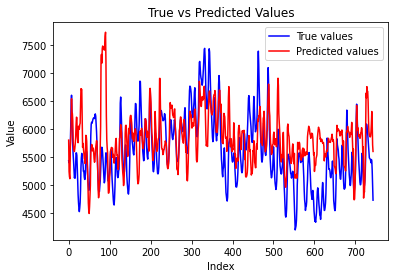

In [181]:
# Plotting true values
plt.plot(y_true, label='True values', color='blue')

# Plotting predicted values
plt.plot(y_pred, label='Predicted values', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')

# Adding legend
plt.legend()

# Show plot
plt.show()

In [187]:
final_data = feature_addition(df_pjm_load_spring)
final_data

,datetime,datetime_beginning_ept,mw,t-24,t-23,t-22,t-21,hour,date,month
24,2023-04-02 00:00:00,4/2/2023 0:00,4424.583,4535.860,4329.427,4228.328,4178.324,0,2,4
25,2023-04-02 01:00:00,4/2/2023 1:00,4374.164,4329.427,4228.328,4178.324,4209.014,1,2,4
26,2023-04-02 02:00:00,4/2/2023 2:00,4362.282,4228.328,4178.324,4209.014,4256.670,2,2,4
27,2023-04-02 03:00:00,4/2/2023 3:00,4384.936,4178.324,4209.014,4256.670,4410.003,3,2,4
28,2023-04-02 04:00:00,4/2/2023 4:00,4442.917,4209.014,4256.670,4410.003,4565.538,4,2,4
...,...,...,...,...,...,...,...,...,...,...
2179,2023-06-30 19:00:00,6/30/2023 19:00,6317.317,6493.032,6208.476,6029.529,5561.762,19,30,6
2180,2023-06-30 20:00:00,6/30/2023 20:00,6120.336,6208.476,6029.529,5561.762,5077.805,20,30,6
2181,2023-06-30 21:00:00,6/30/2023 21:00,5937.785,6029.529,5561.762,5077.805,4751.480,21,30,6
2182,2023-06-30 22:00:00,6/30/2023 22:00,5560.487,5561.762,5077.805,4751.480,4492.181,22,30,6


In [188]:
finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y = train_test(final_data)

In [189]:
fit = model_training(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting model train..
Finished model train..


In [190]:
y_true = np.array(finaldf_test['mw'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')
print('MAPE:', round(mape,2),'%.')

Accuracy: 85.26 %.
MAPE: 14.74 %.


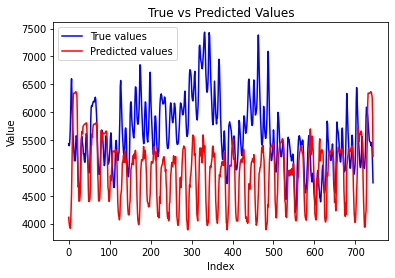

In [191]:
# Plotting true values
plt.plot(y_true, label='True values', color='blue')

# Plotting predicted values
plt.plot(y_pred, label='Predicted values', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')

# Adding legend
plt.legend()

# Show plot
plt.show()

In [196]:
final_data = feature_addition(df_pjm_load_summer)
final_data

,datetime,datetime_beginning_ept,mw,t-24,t-23,t-22,t-21,hour,date,month
24,2023-07-02 00:00:00,7/2/2023 0:00,4750.644,4792.761,4592.205,4401.926,4292.638,0,2,7
25,2023-07-02 01:00:00,7/2/2023 1:00,4519.165,4592.205,4401.926,4292.638,4275.415,1,2,7
26,2023-07-02 02:00:00,7/2/2023 2:00,4342.193,4401.926,4292.638,4275.415,4282.584,2,2,7
27,2023-07-02 03:00:00,7/2/2023 3:00,4254.019,4292.638,4275.415,4282.584,4340.424,3,2,7
28,2023-07-02 04:00:00,7/2/2023 4:00,4219.015,4275.415,4282.584,4340.424,4520.048,4,2,7
...,...,...,...,...,...,...,...,...,...,...
2203,2023-09-30 19:00:00,9/30/2023 19:00,5130.454,5219.729,5121.413,4912.828,4655.916,19,30,9
2204,2023-09-30 20:00:00,9/30/2023 20:00,4999.212,5121.413,4912.828,4655.916,4361.132,20,30,9
2205,2023-09-30 21:00:00,9/30/2023 21:00,4786.570,4912.828,4655.916,4361.132,4133.417,21,30,9
2206,2023-09-30 22:00:00,9/30/2023 22:00,4520.885,4655.916,4361.132,4133.417,3996.115,22,30,9


In [197]:
finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y = train_test(final_data)

In [198]:
fit = model_training(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting model train..
Finished model train..


In [199]:
y_true = np.array(finaldf_test['mw'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')
print('MAPE:', round(mape,2),'%.')

Accuracy: 87.17 %.
MAPE: 12.83 %.


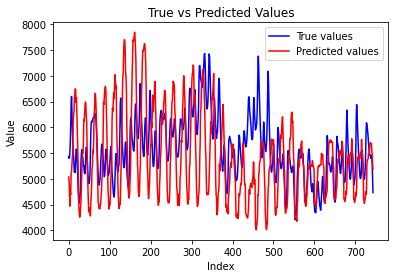

In [200]:
# Plotting true values
plt.plot(y_true, label='True values', color='blue')

# Plotting predicted values
plt.plot(y_pred, label='Predicted values', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')

# Adding legend
plt.legend()

# Show plot
plt.show()

In [201]:
final_data = feature_addition(df_pjm_load_fall)
final_data

,datetime,datetime_beginning_ept,mw,t-24,t-23,t-22,t-21,hour,date,month
24,2023-10-02 00:00:00,10/2/2023 0:00,4043.349,4042.513,3850.067,3734.200,3687.402,0,2,10
25,2023-10-02 01:00:00,10/2/2023 1:00,3942.014,3850.067,3734.200,3687.402,3679.819,1,2,10
26,2023-10-02 02:00:00,10/2/2023 2:00,3875.905,3734.200,3687.402,3679.819,3689.471,2,2,10
27,2023-10-02 03:00:00,10/2/2023 3:00,3884.968,3687.402,3679.819,3689.471,3779.780,3,2,10
28,2023-10-02 04:00:00,10/2/2023 4:00,3959.682,3679.819,3689.471,3779.780,3900.555,4,2,10
...,...,...,...,...,...,...,...,...,...,...
2203,2023-12-31 19:00:00,12/31/2023 19:00,5896.602,6115.244,6034.952,5859.020,5676.595,19,31,12
2204,2023-12-31 20:00:00,12/31/2023 20:00,5758.356,6034.952,5859.020,5676.595,5442.550,20,31,12
2205,2023-12-31 21:00:00,12/31/2023 21:00,5610.514,5859.020,5676.595,5442.550,5292.831,21,31,12
2206,2023-12-31 22:00:00,12/31/2023 22:00,5467.885,5676.595,5442.550,5292.831,5180.083,22,31,12


In [202]:
finaldf_train_x, finaldf_train_y, finaldf_test_x, finaldf_test_y = train_test(final_data)

In [203]:
fit = model_training(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting model train..
Finished model train..


In [204]:
y_true = np.array(finaldf_test['mw'])
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')
print('MAPE:', round(mape,2),'%.')

Accuracy: 91.11 %.
MAPE: 8.89 %.


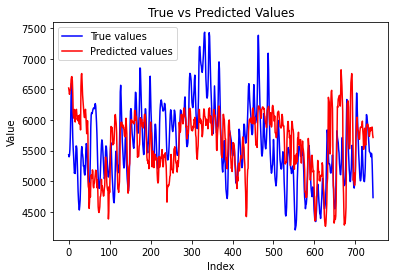

In [205]:
# Plotting true values
plt.plot(y_true, label='True values', color='blue')

# Plotting predicted values
plt.plot(y_pred, label='Predicted values', color='red')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')

# Adding legend
plt.legend()

# Show plot
plt.show()

## Results and Conclusion

Model accuracy varied across different seasons:
Winter: Accuracy of 91.4%
Spring: Accuracy of 85.26%
Summer: Accuracy of 87.17%
Fall: Accuracy of 91.11%
These accuracy scores indicate the model's ability to predict load values, with higher accuracy during winter compared to other seasons.Let's visualize the results before concluding.




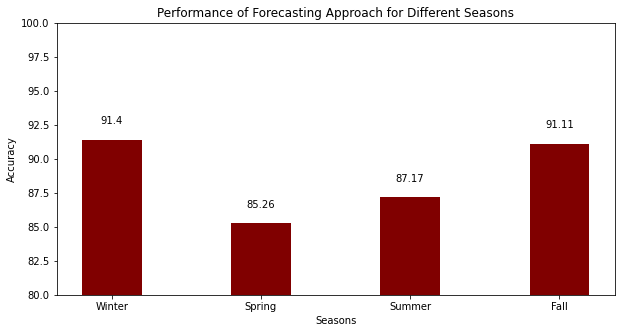

In [208]:
# creating the dataset
data = {'Winter':91.4, 'Spring':85.26, 'Summer':87.17, 
        'Fall':91.11}
Seasons = list(data.keys())
Accuracy = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Seasons, Accuracy, color ='maroon', 
        width = 0.4)
 # Adding values on top of the bars
for i, value in enumerate(Accuracy):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
    
plt.ylim(80,100)
plt.xlabel("Seasons")
plt.ylabel("Accuracy")
plt.title("Performance of Forecasting Approach for Different Seasons")
plt.show()

## Insights

The analysis revealed distinct load patterns across different seasons, influenced by factors such as temperature, daylight hours, and human behavior.
Lag features and temporal features significantly improved the model's predictive performance, capturing underlying load dependencies and seasonal trends.
Further research could focus on incorporating additional features such as weather data to enhance load forecasting accuracy.
